In [5]:
import sacc
import numpy as np
import pyccl as ccl
import rosatX as rx
import pyatomdb
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

## Loading the data

In [33]:
rmf = fits.open('data/pspcb_gain2_256.rmf')
arf = fits.open('data/pspcb_gain2_256.arf')
cls_cov = sacc.Sacc.load_fits('data/cls_cov_y3.fits')

ROSAT, DESY3wl__0, cov__0 = cls_cov.get_ell_cl('cl_0e', 'ROSAT', 'DESY3wl__0', return_cov=True)
err__0 = np.sqrt(np.diagonal(cov__0))

ROSAT, DESY3wl__1, cov__1 = cls_cov.get_ell_cl('cl_0e', 'ROSAT', 'DESY3wl__1', return_cov=True)
err__1 = np.sqrt(np.diagonal(cov__1))

ROSAT, DESY3wl__2, cov__2 = cls_cov.get_ell_cl('cl_0e', 'ROSAT', 'DESY3wl__2', return_cov=True)
err__2 = np.sqrt(np.diagonal(cov__2))

ROSAT, DESY3wl__3, cov__3 = cls_cov.get_ell_cl('cl_0e', 'ROSAT', 'DESY3wl__3', return_cov=True)
err__3 = np.sqrt(np.diagonal(cov__3))

## Initialising defaults and tracers

In [34]:
cosmo = ccl.CosmologyVanillaLCDM()
mdef = ccl.halos.MassDef200c
cM = ccl.halos.ConcentrationDuffy08(mass_def=mdef)

dmat = ccl.halos.HaloProfileNFW(mass_def=mdef, concentration=cM)

nM = ccl.halos.MassFuncTinker08(mass_def=mdef)
bM = ccl.halos.HaloBiasTinker10(mass_def=mdef)
hmc = ccl.halos.HMCalculator(mass_function=nM,
                             halo_bias=bM,
                             mass_def=mdef,
                             log10M_max=15., log10M_min=10, nM=32)

# X-ray tracer
tx = rx.XrayTracer(cosmo)

zs = cls_cov.tracers['DESY3wl__0'].z
nz = cls_cov.tracers['DESY3wl__0'].nz

# gamma tracer
ts = ccl.WeakLensingTracer(cosmo, dndz=(zs, nz))

### Correcting for the smoothing

In [10]:
def pixel_FWHM(nside):
    """
    Returns the FWHM of the HEALPix pixel with nside = nside
    """
    fwhm_hp_amin =  60 * 41.7 / nside
    return np.radians(fwhm_hp_amin/60)/2.355

sigma_ROSAT = np.radians(1.8e0/60)/2.355
sigma_HEALPix = pixel_FWHM(1024)

sigma_tot_2 = sigma_ROSAT**2 + 2*sigma_HEALPix**2

def cl_smoothing_factor(ell):
    return np.exp(-0.5*sigma_tot_2*ell*(1+ell))

## Calculating the X-ray Spectrum

In [11]:
kTmin = 0.02
kTmax = 50.0
nkT = 32
zmax = 4.0
nz = 16
emin = 0.5
emax = 2.0

rosat_spectrum = pyatomdb.spectrum.CIESession()
rosat_spectrum.set_response(rmf, arf)
rosat_spectrum.set_abund(26,0.3)

J_tot = rosat_spectrum.return_integrated_spectrum_interp(kTmin, kTmax, nkT, zmax, nz, emin, emax)

## Calculating the X-ray profiles

In [12]:
a = 1.
x = np.geomspace(0.001, 5, 128)
M = 1e14

r200 = mdef.get_radius(cosmo, M, a) / a
r = r200*x

density_he = rx.HaloProfileDensityHE(mass_def=mdef, concentration=cM,
                                                         kind='n_total')
pressure_he = rx.HaloProfilePressureHE(mass_def=mdef, concentration=cM,
                                                           kind='n_total', kind_T='T_total')
x_he = rx.HaloProfileXray(mass_def=mdef, J=J_tot, dens=density_he, pres=pressure_he,
                          fourier_approx=False,
                          with_clumping=True)

## Calculating the $P(k)$s and $C_\ell$s

In [13]:
k_arr = np.geomspace(1e-4,1e2,256)
a_arr = np.linspace(0.3,1,8)

ls = np.unique(np.geomspace(2, 3100, 128).astype(int)).astype(float)

pk_he = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat, prof2=x_he,
                               lk_arr=np.log(k_arr), a_arr=a_arr)
cl_he = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_he)

# Add smoothing
cl_he *= cl_smoothing_factor(ls)

## Plots

Text(0, 0.5, '$C_\\ell$')

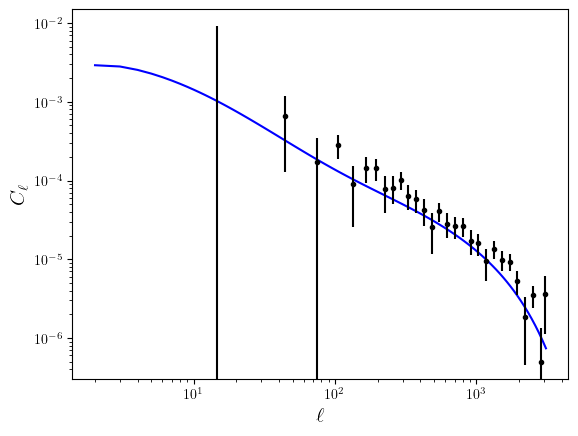

In [17]:
plt.plot(ls, cl_he, 'b')
plt.errorbar(ROSAT, DESY3wl__2, yerr=err, fmt='k.')
plt.loglog()
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)

#plt.savefig('Plots/Cls_Comparison.pdf');

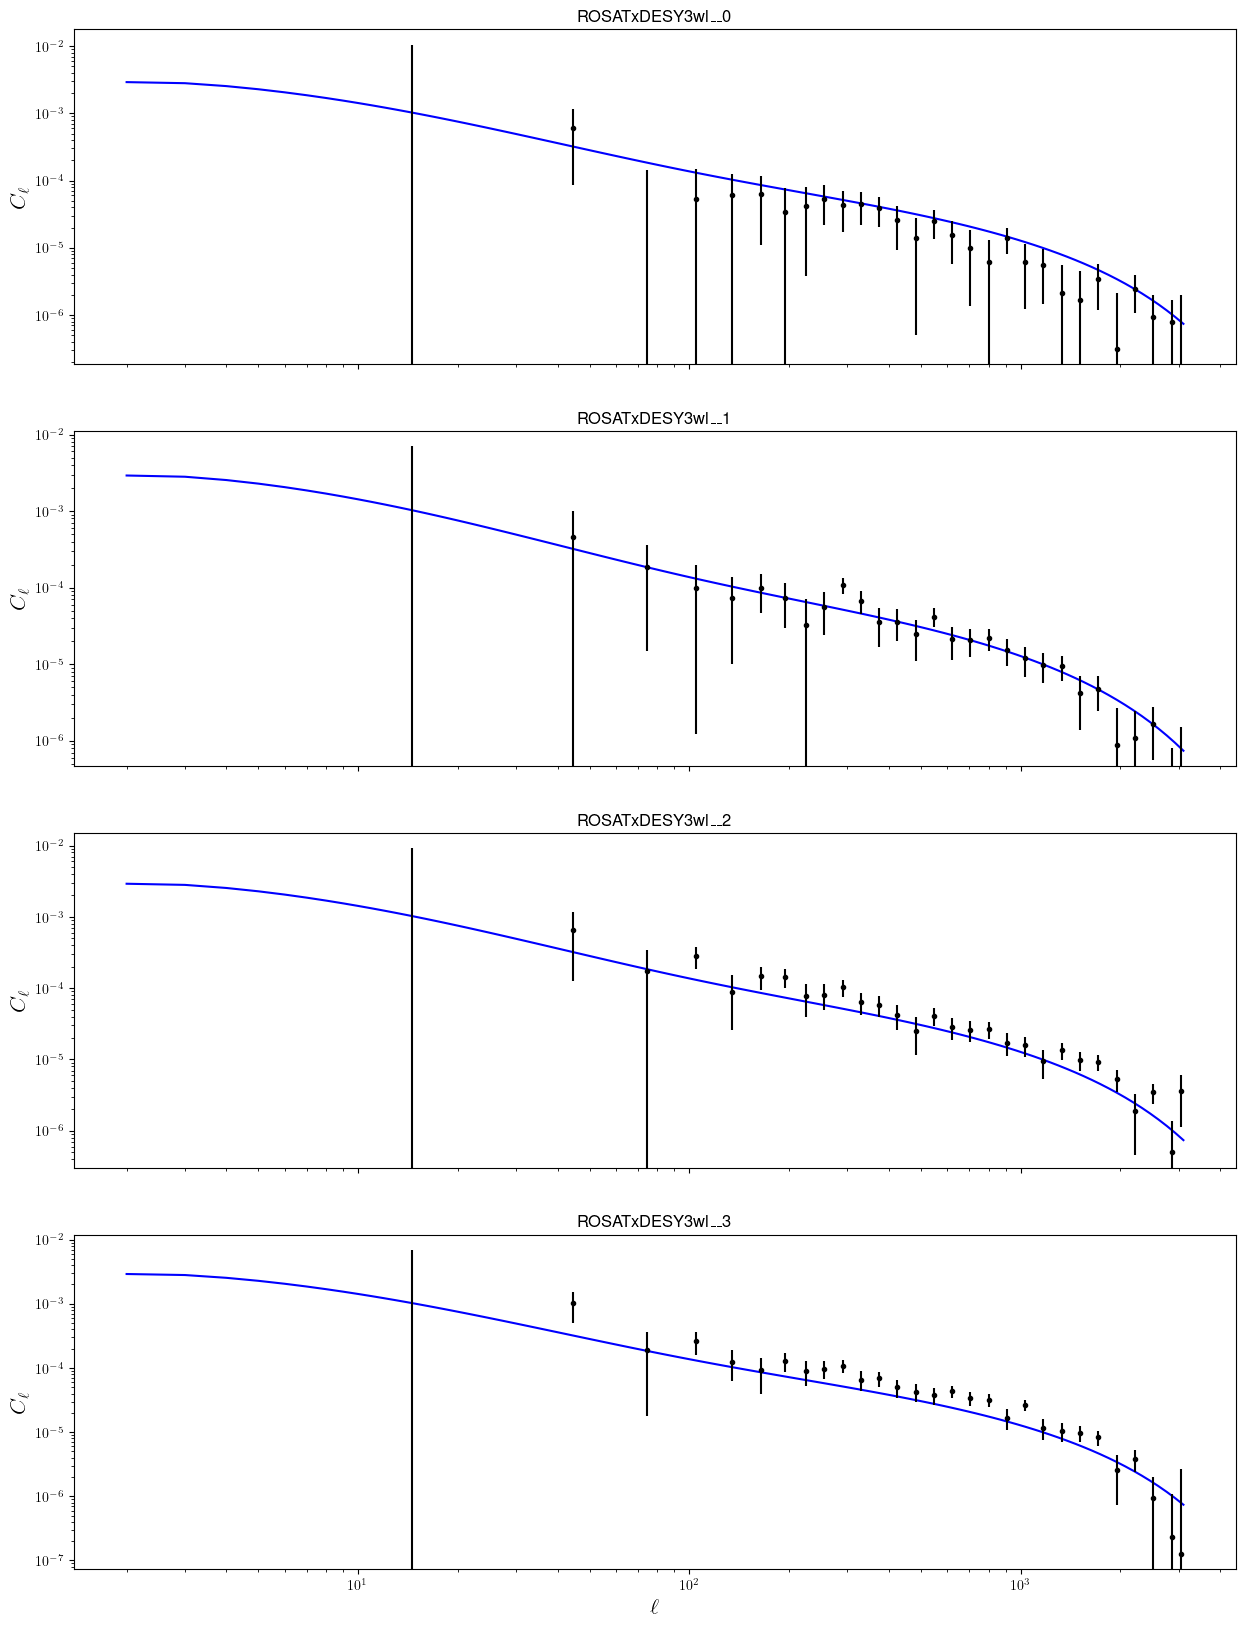

In [59]:
fig, ax = plt.subplots(4, 1, figsize=(15, 20))
    
ax[0].plot(ls, cl_he, 'b')
ax[0].errorbar(ROSAT, DESY3wl__0, yerr=err, fmt='k.')
ax[0].xaxis.set_tick_params(labelbottom=False)
ax[0].set_title(r'ROSATxDESY3wl__0')

ax[1].plot(ls, cl_he, 'b')
ax[1].errorbar(ROSAT, DESY3wl__1, yerr=err, fmt='k.')
ax[1].xaxis.set_tick_params(labelbottom=False)
ax[1].set_title(r'ROSATxDESY3wl__1')

ax[2].plot(ls, cl_he, 'b')
ax[2].errorbar(ROSAT, DESY3wl__2, yerr=err, fmt='k.')
ax[2].xaxis.set_tick_params(labelbottom=False)
ax[2].set_title(r'ROSATxDESY3wl__2')

ax[3].plot(ls, cl_he, 'b')
ax[3].errorbar(ROSAT, DESY3wl__3, yerr=err, fmt='k.')
ax[3].set_title(r'ROSATxDESY3wl__3')

ax[0].loglog()
ax[1].loglog()
ax[2].loglog()
ax[3].loglog()
    
ax[0].set_ylabel(r'$C_\ell$', fontsize=16)
ax[1].set_ylabel(r'$C_\ell$', fontsize=16)
ax[2].set_ylabel(r'$C_\ell$', fontsize=16)
ax[3].set_ylabel(r'$C_\ell$', fontsize=16)

ax[3].set_xlabel(r'$\ell$', fontsize=16);

fig.savefig('Plots/HE_Cls.pdf')